In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import time
import copy
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [95]:
import os
from sklearn.model_selection import train_test_split

annotation_file = pd.DataFrame(columns=["img_name", "label"])

files_types = ['txt', 'ppt', 'pdf', 'doc', 'jpg', 'gz', 'html', 'ps', 'xls']

for idx, t in enumerate(files_types):
	tmp_df = pd.DataFrame(columns=["img_name"])
	tmp_df["img_name"] = os.listdir("data/FragmentsGray/" + t)
	tmp_df = tmp_df.assign(label=idx)
	annotation_file = annotation_file.append(tmp_df, sort=False)

train, test = train_test_split(annotation_file, test_size=0.10)

print(train.describe())
print(test.describe())
train.to_csv("trainingSet.csv", index=False)
test.to_csv("validationSet.csv", index=False)

         img_name   label
count      815543  815543
unique     102108       9
top     88475.jpg       1
freq            9   92062
         img_name  label
count       90616  90616
unique      61707      9
top     13115.jpg      7
freq            6  10193


In [3]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image

files_types = ['txt', 'ppt', 'pdf', 'doc', 'jpg', 'gz', 'html', 'ps', 'xls']

class CustomDataset(Dataset):
	def __init__(self, root_dir, annotation_file, transform=None):
		self.root_dir = root_dir
		self.annotations = annotation_file
		self.transform = transform

	def __len__(self):
		return len(self.annotations)

	def __getitem__(self, index):
		img_id = self.annotations.iloc[index, 0]
		img = Image.open(os.path.join(self.root_dir, files_types[self.annotations.iloc[index, 1]], img_id))
		y_label = self.annotations.iloc[index, 1]

		if self.transform is not None:
			img = self.transform(img)

		return (img, y_label)

In [205]:
trainingSet = pd.read_csv("trainingSet.csv")
validationSet = pd.read_csv("validationSet.csv")

transform = transforms.Compose(
    [transforms.ToTensor()])

# size of the mini batch
num_epochs = 20
learning_rate = 0.00001
train_CNN = False
batch_size = 64
shuffle = True
pin_memory = True
num_workers = 30
nb_training = 300000
nb_validation = 50000

train_dataset = CustomDataset("data/FragmentsGray", trainingSet, transform=transform)
validation_dataset = CustomDataset("data/FragmentsGray", validationSet, transform=transform)

train_set, _, _ = torch.utils.data.random_split(train_dataset, [nb_training, 0, len(trainingSet) - nb_training])
_, validation_set, _ = torch.utils.data.random_split(validation_dataset, [0, nb_validation, len(validationSet) - nb_validation])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers,
                          pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=pin_memory)


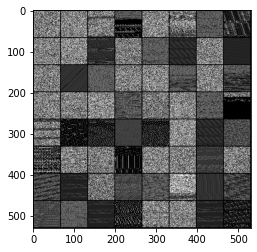

tensor([5, 5, 2, 3, 1, 2, 6, 8, 5, 1, 0, 4, 6, 0, 2, 6, 4, 0, 6, 5, 5, 6, 4, 6,
        4, 5, 2, 6, 4, 5, 6, 3, 2, 8, 8, 7, 8, 4, 0, 6, 3, 3, 1, 8, 2, 2, 7, 1,
        6, 0, 4, 6, 0, 2, 7, 6, 6, 6, 0, 8, 1, 1, 0, 8])


In [128]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, filename=''):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if filename == '':
        plt.show()
    else:
        plt.savefig(filename)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [216]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 32, 3,stride=1)
        self.conv3 = nn.Conv2d(32, 64, 3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(64, 126, 3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(126, 256, 3,stride=1,padding=1)
        self.fc1 = nn.Linear(2304, 1600)
        self.fc2 = nn.Linear(1600, 600)
        self.fc3 = nn.Linear(600, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Net()
model = model.to(device)
print(model)

def get_n_params(model):
  sum=0
  for layers in list(model.parameters()):
      nbLayer=1
      for size in list(layers.size()):
          nbLayer = nbLayer*size
      sum += nbLayer
    
  return sum
print(get_n_params(model))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(126, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=9, bias=True)
)
5045335


In [206]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [203]:
def check_accuracy(loader, model):
	if loader == train_loader:
		print("Checking accuracy on training data")
	else:
		print("Checking accuracy on validation data")

	num_correct = 0
	num_samples = 0
	model.eval()

	with torch.no_grad():
		for x, y in loader:
			x = x.to(device=device)
			y = y.to(device=device)

			scores = model(x)
			predictions = torch.argmax(scores, dim=1).to(device)
			num_correct += (predictions == y).sum()
			num_samples += predictions.size(0)
		print(
			f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
		)
	model.train()
	return float(num_correct) / float(num_samples) * 100

In [204]:
best_accurency = 0
best_model = copy.deepcopy(model)
model.train()
for epoch in range(num_epochs):
	loop = tqdm(train_loader, total=len(train_loader), leave=True)
	if epoch % 1 == 0:
		accu = check_accuracy(validation_loader, model)
		if accu > best_accurency:
			best_model = copy.deepcopy(model)
			best_accurency = accu
		loop.set_postfix(val_acc=accu)
	for imgs, labels in loop:
		imgs = imgs.to(device)
		labels = labels.to(device)
		outputs = model(imgs)
		loss = criterion(outputs, labels)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
		loop.set_postfix(loss=loss.item())

accu = check_accuracy(validation_loader, model)
if accu > best_accurency:
	best_model = copy.deepcopy(model)
	best_accurency = accu

torch.save(best_model.state_dict(), "model.pt")

  0%|          | 0/1563 [00:00<?, ?it/s]

Checking accuracy on validation data


  0%|          | 0/1563 [00:07<?, ?it/s, val_acc=77.9]

Got 38957 / 50000 with accuracy 77.91


  0%|          | 0/1563 [00:00<?, ?it/s]

Checking accuracy on validation data


  0%|          | 0/1563 [00:07<?, ?it/s, val_acc=78.4]

Got 39187 / 50000 with accuracy 78.37


  0%|          | 0/1563 [00:00<?, ?it/s]

Checking accuracy on validation data


  0%|          | 0/1563 [00:07<?, ?it/s, val_acc=78.5]

Got 39262 / 50000 with accuracy 78.52


  0%|          | 0/1563 [00:00<?, ?it/s]

Checking accuracy on validation data


  0%|          | 0/1563 [00:07<?, ?it/s, val_acc=78.6]

Got 39280 / 50000 with accuracy 78.56


  0%|          | 0/1563 [00:00<?, ?it/s]

Checking accuracy on validation data


  0%|          | 0/1563 [00:07<?, ?it/s, val_acc=78.6]

Got 39307 / 50000 with accuracy 78.61


Epoch [4/5]: 100%|██████████| 1563/1563 [00:43<00:00, 35.86it/s, loss=1.61]

Checking accuracy on validation data


Got 39330 / 50000 with accuracy 78.66


In [217]:
model = Net()
model.load_state_dict(torch.load('model_61.pt'))
model = model.to(device)

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(126, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=9, bias=True)
)


In [212]:
check_accuracy(validation_loader, model)

Checking accuracy on validation data
Got 39492 / 50000 with accuracy 78.98


78.984

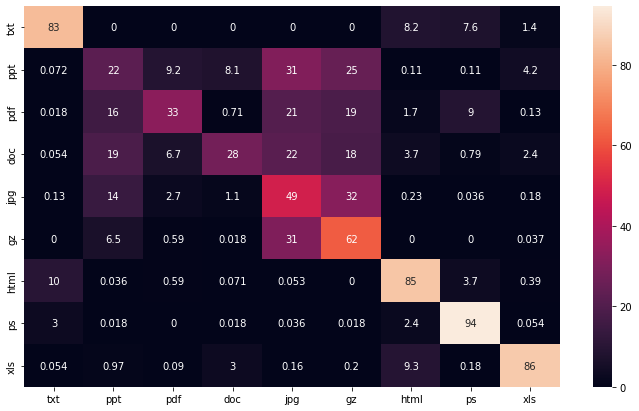

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(126, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=9, bias=True)
)

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

nb_classes = len(files_types)
model.eval()

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validation_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

                
plt.figure(figsize = (12,7))
sns.heatmap([[(j/sum(i))*100 for j in i] for i in confusion_matrix], annot=True, xticklabels=files_types, yticklabels=files_types)
plt.show()
model.train()

In [82]:
classes_balance = [0]*9

for _, cl in train_loader:
    for c in cl:
        classes_balance[c.item()] += 1

s = sum(classes_balance)
print([(i/s)*100 for i in classes_balance])

[11.129, 11.3255, 11.015, 11.047, 10.896500000000001, 10.971, 11.239, 11.3335, 11.0435]


In [137]:
torch.save(model.state_dict(), "model_60.pt")

In [187]:
model = copy.deepcopy(best_model)


In [ ]:
print("hello")